In [1]:
from mlp import MLP
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
%matplotlib inline
data, label = make_moons(n_samples=1000, noise=0.2)

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: invalid device ordinal)


(1000, 2)
(1000,)


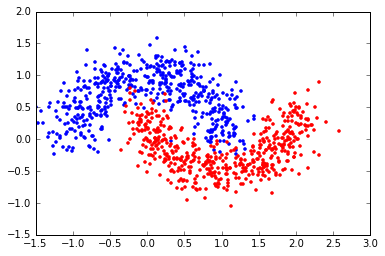

In [2]:
print(data.shape)
print(label.shape)

plt.plot(data[label==0,0], data[label==0,1],'.')
plt.plot(data[label==1,0], data[label==1,1],'r.')

# Using MLP with sklearn's cross_val_score

In [3]:

from sklearn.cross_validation import cross_val_score

clf = MLP(n_hidden=10, n_deep=3, l1_norm=0, drop=0.1, verbose=0)

scores = cross_val_score(clf, data, label, cv=5, n_jobs=-1, scoring='f1_weighted')
print(scores)

[ 0.94997999  0.86483442  0.969988    0.93495935  0.95497186]


# Using MLP with sklearn's GridSearchCV

In [29]:
from sklearn.grid_search import GridSearchCV

params = {'n_hidden': [10, 15], 
         'l1_norm': [0.0],
         'n_deep': [2, 3],
         'drop': [0.1]}

clf_grid = GridSearchCV(clf, param_grid=params, scoring='f1_weighted', cv=5, n_jobs=-1)
scores = cross_val_score(clf_grid, data, label, cv=5, n_jobs=1, scoring='f1_weighted')
print(scores)

[ 0.96499212  0.969997    0.95996397  0.97499437  0.95497186]
